In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

# 1. Loading the data

Using a standard convolutional network augmented with a spatial transformer network to experiment with the classic MNIST dataset.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True, 
                   transform = transforms.Compose([   # Pipeline
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

0it [00:00, ?it/s]

9920512it [00:02, 4284860.63it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 110227.79it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:00, 1739793.77it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 41875.21it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


# 2. Modeling

Spatial transformer networks boils down to three main components :

- The localization network is a regular CNN which regresses the transformation parameters. The transformation is never learned explicitly from this dataset, instead the network learns automatically the **spatial transformations** that enhances the global accuracy.
- The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image.
- The sampler uses the parameters of the transformation and applies it to the input image.

In [4]:
class Net(nn.Module):
    
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # Spatial transformer localization network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0],
            dtype=torch.float))
        
        
    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
            
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
            
        return x
        
        
    def forward(self, x):
        # Transform the input
        x = self.stn(x)
            
        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
        
        
        
model = Net().to(device)    

# 3. Training the model

Use the SGD algorithm to train the model. The network is learning the classification task in a supervised way. In the same time the model is learning STN automatically in an end-to-end fashion.

In [5]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

# A simple test procedure to measure STN performances on MNIST.


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            
            # Get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
             .format(test_loss, correct, len(test_loader.dataset), 
                     100. * correct / len(test_loader.dataset)))
    

# 4. Visualizing the STN results

We define a small helper function in order to visualize the transformations while training.



/home/kevinxu/.local/lib/python3.6/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/kevinxu/.local/lib/python3.6/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.093702
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.081828


/home/kevinxu/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0394, Accuracy: 9870/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.112809
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.023180

Test set: Average loss: 0.0429, Accuracy: 9884/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.135027
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.064497

Test set: Average loss: 0.0385, Accuracy: 9887/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.044027
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.252424

Test set: Average loss: 0.0354, Accuracy: 9894/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.028461
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.017758

Test set: Average loss: 0.0421, Accuracy: 9870/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.035980
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.009449

Test set: Average loss: 0.5904, Accuracy: 8393/10000 (84%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.295296
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.057186

Test set: Average loss: 0.0354, Accuracy: 9898/10000 (99%)

Tra

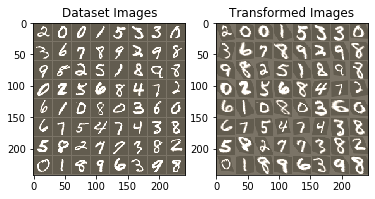

In [7]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    return inp

# Visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)
        
        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))
        
        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        
        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        
        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

        
for epoch in range(1, 20 + 1):
    train(epoch)
    test()
    
# visualize the SYN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

In [3]:
# License: BSD`
# Author: Ghassen Hamrouni